In [1]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
# Config Values
PHASE_IMAGES = 800_000
Z_DIM = 512
MAX_RESOLUTION = 128 # MAX 1024
IMG_C = 3
LR = 0.001
B1 = 0
B2 = 0.99
E_OPT = 10e-8
E_DRIFT = 0.001
WG_N_CRITIC = 1
WG_LAMBDA = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZES = [16, 16, 16, 16, 10, 4, 2, 2, 2]
DATAROOT = './celeba_hq_256'
LOAD_MODEL = True
STARTING_TRAIN_LAYER = 5
SKIP_STARTING_FADE_IN = False
STARTING_IMAGES = 0

# Static Config Values
LAYERS = [Z_DIM, Z_DIM, Z_DIM, Z_DIM, Z_DIM//2, Z_DIM//4, Z_DIM//8, Z_DIM//16, Z_DIM//32]

# Config functions
def getLayers():
    return LAYERS[:int(log2(MAX_RESOLUTION)) - 1]

In [3]:
# Visualizes images given a tensor of images, number of images, and
# size per image, plots and prints the images in a uniform grid.
def show_tensor_images(image_tensor, num_images=15, size=(1, 32, 32)):
    # Clip between 0 - 1
    image_tensor = image_tensor / 2 + 0.5

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.show()

# Calculates gradient penalty from WGAN-GP paper
def gradient_penalty(critic, real, fake, step, alpha, device="cpu"):
    # clip fake examples to be same number as real if different
    if real.shape[0] != fake.shape[0]:
        fake = fake[: real.shape[0], :, :, :]

    N, C, H, W = real.shape
    epsilons = torch.rand((N, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolation = epsilons * real + (1 - epsilons) * fake

    scores = critic(interpolation, step, alpha)

    gradient = torch.autograd.grad(
        inputs=interpolation,
        outputs=scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty


In [4]:
# Dataloader
def getDataLoader(img_size=64, batch_size=16):
    transform_list = transforms.Compose([
       transforms.Resize((img_size, img_size), transforms.InterpolationMode.BICUBIC),
       transforms.CenterCrop(img_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = dset.ImageFolder(root=DATAROOT, transform=transform_list)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [5]:
# Normalizes over each pixel in all channels of a layer to dissuade generator from
# growing in magnitude (which leads to training instability with critic competition)
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.e = 1e-7

    def forward(self, x):
        return x / torch.sqrt(
            torch.mean(x ** 2, dim=1, keepdim=True) + self.e
        )  # N, C, H, W

# Creates a convolutional layer that equalizes learning rate across 
# weights to ensure lr affects all weights equally. Applies this equalization at run-time.
class EqualizedConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel, stride, padding)
        self.scale = (2 / (in_c * kernel * kernel)) ** 0.5

        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


# Creates convolutional block that encapsulates a typical ProGAN layer
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, discriminator_block=False):
        super().__init__()
        self.conv1 = nn.Sequential(
            EqualizedConv2d(in_c, in_c if discriminator_block else out_c),
            nn.LeakyReLU(),
        )
        self.conv2 = nn.Sequential(
            EqualizedConv2d(in_c if discriminator_block else out_c, out_c),
            nn.LeakyReLU(),
        )
        self.pn = PixelNorm()
        self.use_pixel_norm = not discriminator_block

    def forward(self, x):
        x = self.conv1(x)
        if self.use_pixel_norm:
            x = self.pn(x)
        x = self.conv2(x)
        if self.use_pixel_norm:
            x = self.pn(x)

        return x


class Generator(nn.Module):
    def __init__(self, img_c, channels_per_layer):
        super().__init__()

        ## First Layer
        initial_transpose = nn.Sequential(
            nn.ConvTranspose2d(
                channels_per_layer[0],
                channels_per_layer[0],
                stride=1,
                padding=0,
                kernel_size=4,
            ),
            nn.LeakyReLU(),
            PixelNorm(),
            EqualizedConv2d(channels_per_layer[0], channels_per_layer[0]),
            nn.LeakyReLU(),
            PixelNorm(),
        )

        initial_rgb = EqualizedConv2d(channels_per_layer[0], img_c, padding=1, stride=1)

        ## Progressive Growing Layers
        self.progressive_growth, self.progressive_rgb = (
            nn.ModuleList([initial_transpose]),
            nn.ModuleList([initial_rgb]),
        )

        for layer in range(1, len(channels_per_layer)):
            self.progressive_growth.append(
                ConvBlock(channels_per_layer[layer - 1], channels_per_layer[layer])
            )
            self.progressive_rgb.append(
                EqualizedConv2d(channels_per_layer[layer], img_c, padding=1, stride=1)
            )

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    # Current_step goes from 0-len(channels_per_layer)-1
    def forward(self, x, current_step, alpha):
        # If first layer is the only step then avoid fade in
        if current_step == 0:
            x = self.progressive_growth[0](x)
            x = self.progressive_rgb[0](x)

        # If more than one layer do fade in for final layer
        else:
            for step in range(current_step + 1):
                # Non-Final Step
                if step != current_step:
                    x = self.progressive_growth[step](x)
                    x = F.interpolate(x, scale_factor=2, mode="nearest")  # upscale

                # Final Step
                else:
                    upscaled = x
                    generated = self.progressive_growth[step](x)
                    generated_rgb = self.progressive_rgb[step](generated)
                    upscaled_rbg = self.progressive_rgb[step - 1](upscaled)
                    x = self.fade_in(alpha, upscaled_rbg, generated_rgb)

        return x


class Critic(nn.Module):
    def __init__(self, img_c, channels_per_layer):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(2, 2)

        self.progressive_shrink, self.progressive_rgb = (
            nn.ModuleList([]),
            nn.ModuleList([]),
        )

        # Final layer of discriminator / first pass at 4x4 is slightly different structure
        self.progressive_rgb.append(
            nn.Sequential(
                EqualizedConv2d(
                    img_c, channels_per_layer[0], kernel=1, stride=1, padding=0
                ),
                nn.LeakyReLU(),
            )
        )

        self.progressive_shrink.append(
            nn.Sequential(
                # Minibatch std adds one extra channel before this layer
                EqualizedConv2d(
                    channels_per_layer[0] + 1,
                    channels_per_layer[0],
                    kernel=3,
                    stride=1,
                    padding=1,
                ),
                nn.LeakyReLU(),
                EqualizedConv2d(channels_per_layer[0], 1, kernel=4, stride=1, padding=0)
                # Skipping linear because it likely is not needed
            )
        )

        for layer in range(1, len(channels_per_layer)):
            self.progressive_rgb.append(
                EqualizedConv2d(
                    img_c, channels_per_layer[layer], kernel=1, stride=1, padding=0
                )
            )
            self.progressive_shrink.append(
                ConvBlock(
                    channels_per_layer[layer],
                    channels_per_layer[layer - 1],
                    discriminator_block=True,
                )
            )

    def fade_in(self, alpha, downscaled, generated):
        return alpha * generated + (1 - alpha) * downscaled

    def minibatch_std_dev(self, x):
        return torch.cat(
            (
                x,
                torch.std(x, dim=0)
                .mean()
                .repeat(x.shape[0], 1, x.shape[2], x.shape[3]),
            ),
            dim=1,
        )

    def forward(
        self, x, current_step, alpha
    ):  # Note that current step starts at 0 and goes until len(layers)-1
        for step in range(current_step, 0, -1):
            # If we are on the first step then take image from RGB and scale it in
            if step == current_step:
                downscaled = self.progressive_rgb[step - 1](self.avg_pool(x))
                generated = self.progressive_rgb[step](x)
                generated = self.avg_pool(self.progressive_shrink[step](generated))
                x = self.fade_in(alpha, downscaled, generated)
            else:
                x = self.avg_pool(self.progressive_shrink[step](x))

        # Do final step with minibatch std-dev
        if current_step == 0:
            x = self.progressive_rgb[0](x)
        x = self.minibatch_std_dev(x)
        x = self.progressive_shrink[0](x)

        return x


Testing generator
Test layer 1
Test layer 2
Test layer 3
Test layer 4
Test layer 5
Generator tests finished successfully
Testing critic
Test layer 1
Test layer 2
Test layer 3
Test layer 4
Test layer 5
Critic tests finished successfully


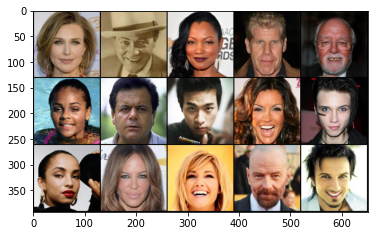

In [6]:
# Tests
IMG_C_T = 3
N_T = 32
Z_DIM_T = 512
CHANNELS_PER_LAYER_T = [Z_DIM_T, Z_DIM_T, Z_DIM_T, Z_DIM_T, Z_DIM_T // 2] # Each layer increase size by 2. First layer starts at 4x4

gen = Generator(IMG_C_T, CHANNELS_PER_LAYER_T)
crit = Critic(IMG_C_T, CHANNELS_PER_LAYER_T)
z = torch.randn((N_T, Z_DIM_T, 1, 1))

print('Testing generator')
for i in range(len(CHANNELS_PER_LAYER_T)):
    print(f'Test layer {i + 1}')
    out = gen(z, i, 0.01)
    assert out.shape[2] == out.shape[3]
    assert out.shape[2] == [4, 8, 16, 32, 64][i]
print('Generator tests finished successfully')

print('Testing critic')
IMG_SIZES_T = [4, 8, 16, 32, 64]
for i in range(len(CHANNELS_PER_LAYER_T)):
    print(f'Test layer {i + 1}')
    FAKE_IMAGES = torch.randn((N_T, IMG_C_T, IMG_SIZES_T[i], IMG_SIZES_T[i]))
    out = crit(FAKE_IMAGES, i, 0.01)
    assert out.shape == torch.rand((N_T, 1, 1, 1)).shape
print('Critic tests finished successfully')

# Test dataloader
dataloader = getDataLoader(batch_size=15, img_size=128)
test_images = next(iter(dataloader))[0]
show_tensor_images(test_images, num_images=15, size=(3, 128, 128))

Starting training for epoch 5
Shown 4 images to the generator and on layer 6.
Generator Loss: 6.70683479309082
Critic Loss: 5.539892673492432. 2022-07-26 04:14:58.662755



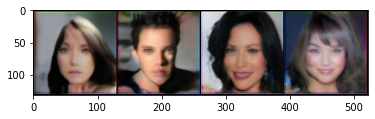

Shown 201600 images to the generator and on layer 6.
Generator Loss: 6.806407928466797
Critic Loss: -2.868959903717041. 2022-07-26 09:21:09.271285



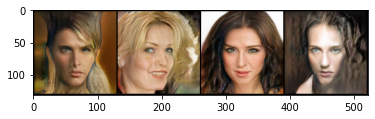

Shown 403200 images to the generator and on layer 6.
Generator Loss: 3.0710983276367188
Critic Loss: -2.5529747009277344. 2022-07-26 14:34:19.819263



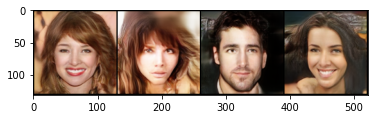

Shown 604800 images to the generator and on layer 6.
Generator Loss: 2.940441131591797
Critic Loss: -1.678674340248108. 2022-07-26 19:42:35.658519



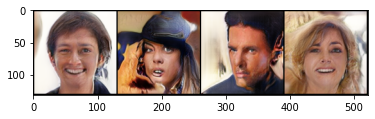

Shown 800000 images to the generator and on layer 6.
Generator Loss: 8.747888565063477
Critic Loss: -5.400567531585693. 2022-07-27 00:38:41.340655



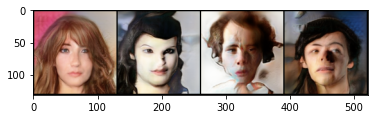

Shown 806400 images to the generator and on layer 6.
Generator Loss: 9.758962631225586
Critic Loss: -3.5249006748199463. 2022-07-27 00:48:23.305639



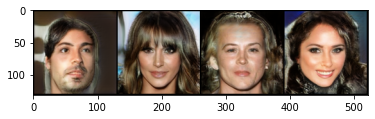

Shown 1008000 images to the generator and on layer 6.
Generator Loss: 6.826223373413086
Critic Loss: -4.6897969245910645. 2022-07-27 05:55:03.214509



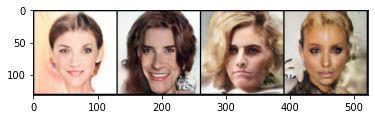

Shown 1209600 images to the generator and on layer 6.
Generator Loss: 7.472280502319336
Critic Loss: -0.9213992357254028. 2022-07-27 11:09:03.977937



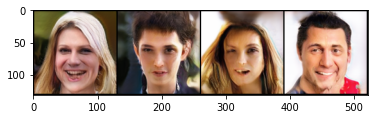

Shown 1411200 images to the generator and on layer 6.
Generator Loss: 3.1270389556884766
Critic Loss: 3.2660465240478516. 2022-07-27 16:33:04.389786



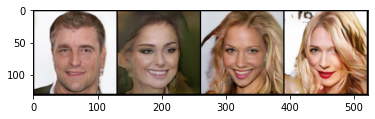

Shown 1612800 images to the generator and on layer 6.
Generator Loss: 6.075309753417969
Critic Loss: 3.3362767696380615. 2022-07-27 21:40:45.917209



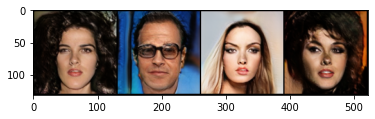

In [7]:
# Training

generator = Generator(IMG_C, getLayers()).to(DEVICE)
critic = Critic(IMG_C, getLayers()).to(DEVICE)

if LOAD_MODEL:
    generator.load_state_dict(torch.load(f'generator{STARTING_TRAIN_LAYER-1}.pth'))
    critic.load_state_dict(torch.load(f'critic{STARTING_TRAIN_LAYER-1}.pth'))

gen_opt = torch.optim.Adam(
    generator.parameters(), LR, (B1, B2), E_OPT
)
crit_opt = torch.optim.Adam(
    critic.parameters(), LR, (B1, B2), E_OPT
)

gen_scaler = torch.cuda.amp.GradScaler()
crit_scaler = torch.cuda.amp.GradScaler()

for epoch in range(STARTING_TRAIN_LAYER, len(getLayers())):
    img_size = (2 ** epoch) * 4
    dataloader = getDataLoader(
        batch_size=BATCH_SIZES[epoch], img_size=img_size
    )

    images_shown = STARTING_IMAGES if (epoch == STARTING_TRAIN_LAYER) else 0
    alpha = 1 if (SKIP_STARTING_FADE_IN and epoch == STARTING_TRAIN_LAYER) else 1e-5
    print(f'Starting training for epoch {epoch}')

    while images_shown < PHASE_IMAGES * 2:        
        for _, (real_images, _) in enumerate(dataloader):
            N, C, H, W = real_images.shape
            images_shown += N
            real_images = real_images.to(DEVICE)

            # Do critic updates
            for i in range(WG_N_CRITIC):
                with torch.cuda.amp.autocast():
                    Z = torch.randn((N, Z_DIM, 1, 1)).to(DEVICE)
                    fake_images = generator(Z, epoch, alpha)[
                        :N, :, :, :
                    ]  # Remove some images if real_images is last of batch

                    penalty = gradient_penalty(
                        critic,
                        real_images,
                        fake_images,
                        epoch,
                        alpha,
                        device=DEVICE,
                    )

                    real_critic = critic(real_images, epoch, alpha).view(-1)
                    fake_critic = critic(fake_images.detach(), epoch, alpha).view(-1)
                    critic_loss = (
                        -(real_critic.mean() - fake_critic.mean())
                        + WG_LAMBDA * penalty
                        + E_DRIFT * (real_critic ** 2).mean()
                    )

                crit_opt.zero_grad()
                crit_scaler.scale(critic_loss).backward(retain_graph=True)
                crit_scaler.step(crit_opt)
                crit_scaler.update()

            # Do generator updates
            with torch.cuda.amp.autocast():
                fake_critic = critic(fake_images, epoch, alpha).view(-1)
                generator_loss = -(fake_critic.mean())

            gen_opt.zero_grad()
            gen_scaler.scale(generator_loss).backward()
            gen_scaler.step(gen_opt)
            gen_scaler.update()

            # Update model parameters
            alpha = (
                images_shown / PHASE_IMAGES
                if images_shown < PHASE_IMAGES
                else 1
            )     
            
            # Display images after 800,000 have been shown to generator
            if images_shown <= N or images_shown - N < PHASE_IMAGES and images_shown >= PHASE_IMAGES or images_shown % 201600 == 0:
                print(
                    f"Shown {images_shown} images to the generator and on layer {epoch + 1}.\nGenerator Loss: {generator_loss}\nCritic Loss: {critic_loss}. {datetime.datetime.now()}\n"
                )
                images_to_show = 5 * round(BATCH_SIZES[epoch] / 5)
                show_tensor_images(
                    fake_images.detach()[:images_to_show, :, :, :],
                    num_images=images_to_show,
                    size=(IMG_C, img_size, img_size),
                )
                torch.save(generator.state_dict(), f'generator{epoch}.pth')
                torch.save(critic.state_dict(), f'critic{epoch}.pth')


In [8]:
torch.save(generator.state_dict(), f'generator{epoch}.pth')
torch.save(critic.state_dict(), f'critic{epoch}.pth')

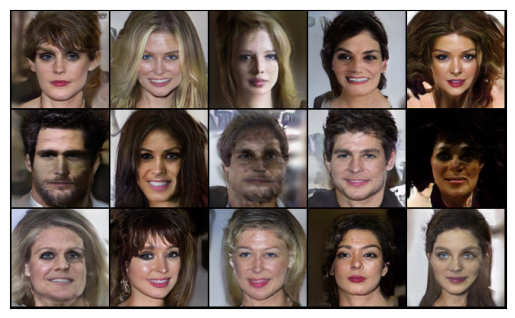

In [9]:
# Generate and display images
Z = torch.clip(torch.randn((15, Z_DIM, 1, 1), device=DEVICE), -0.2, 0.2)
fake_images = generator(Z, 5, 1)

show_tensor_images(
    fake_images.detach()[:, :, :, :],
    num_images=15,
    size=(IMG_C, 128, 128),
)